In [93]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import math
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn import datasets

from scipy.spatial.distance import pdist, squareform
from scipy import linalg

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, adjusted_mutual_info_score

In [59]:
# Load the Iris dataset
iris = load_iris()
data = pd.DataFrame(data=iris.data, columns=iris.feature_names)
data['target'] = iris.target
data['target_name'] = data['target'].map(dict(enumerate(iris.target_names)))
data

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,virginica
146,6.3,2.5,5.0,1.9,2,virginica
147,6.5,3.0,5.2,2.0,2,virginica
148,6.2,3.4,5.4,2.3,2,virginica


In [60]:
data_df = data.drop(["target","target_name"], axis=1)
data_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [61]:
# Get labels and map them to a set for unique class identification
labels = data["target"].tolist()
unique_labels = set(labels)
unique_labels

{0, 1, 2}

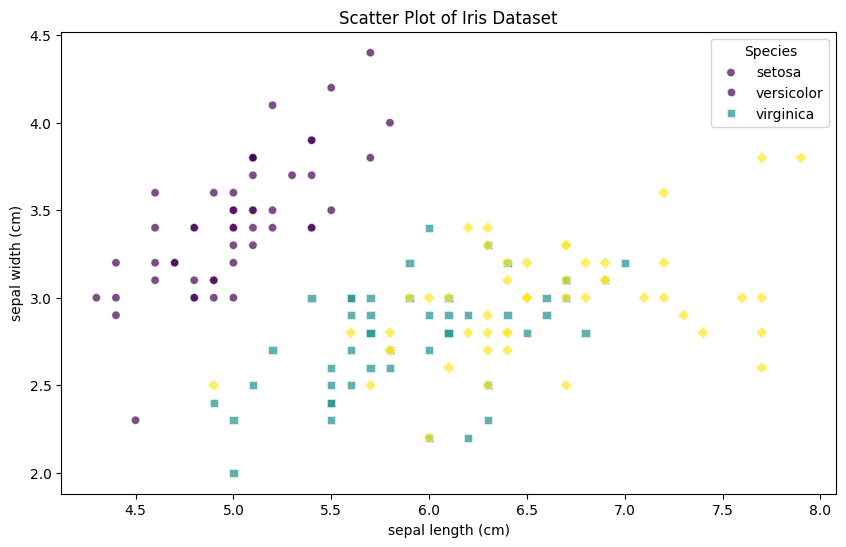

In [62]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_df, x=data_df.columns[0], y=data_df.columns[1], hue=labels, palette='viridis', style=labels, markers=["o", "s", "D"], alpha=0.7)
plt.title("Scatter Plot of Iris Dataset")
plt.xlabel(data_df.columns[0])
plt.ylabel(data_df.columns[1])
plt.legend(title='Species', labels=[iris.target_names[i] for i in unique_labels])
plt.show()

Outliers in sepal length (cm):
 Empty DataFrame
Columns: [sepal length (cm), sepal width (cm), petal length (cm), petal width (cm)]
Index: []
Outliers in sepal width (cm):
     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
15                5.7               4.4                1.5               0.4
32                5.2               4.1                1.5               0.1
33                5.5               4.2                1.4               0.2
60                5.0               2.0                3.5               1.0
Outliers in petal length (cm):
 Empty DataFrame
Columns: [sepal length (cm), sepal width (cm), petal length (cm), petal width (cm)]
Index: []
Outliers in petal width (cm):
 Empty DataFrame
Columns: [sepal length (cm), sepal width (cm), petal length (cm), petal width (cm)]
Index: []
New Shape after removing outliers:  (146, 4)


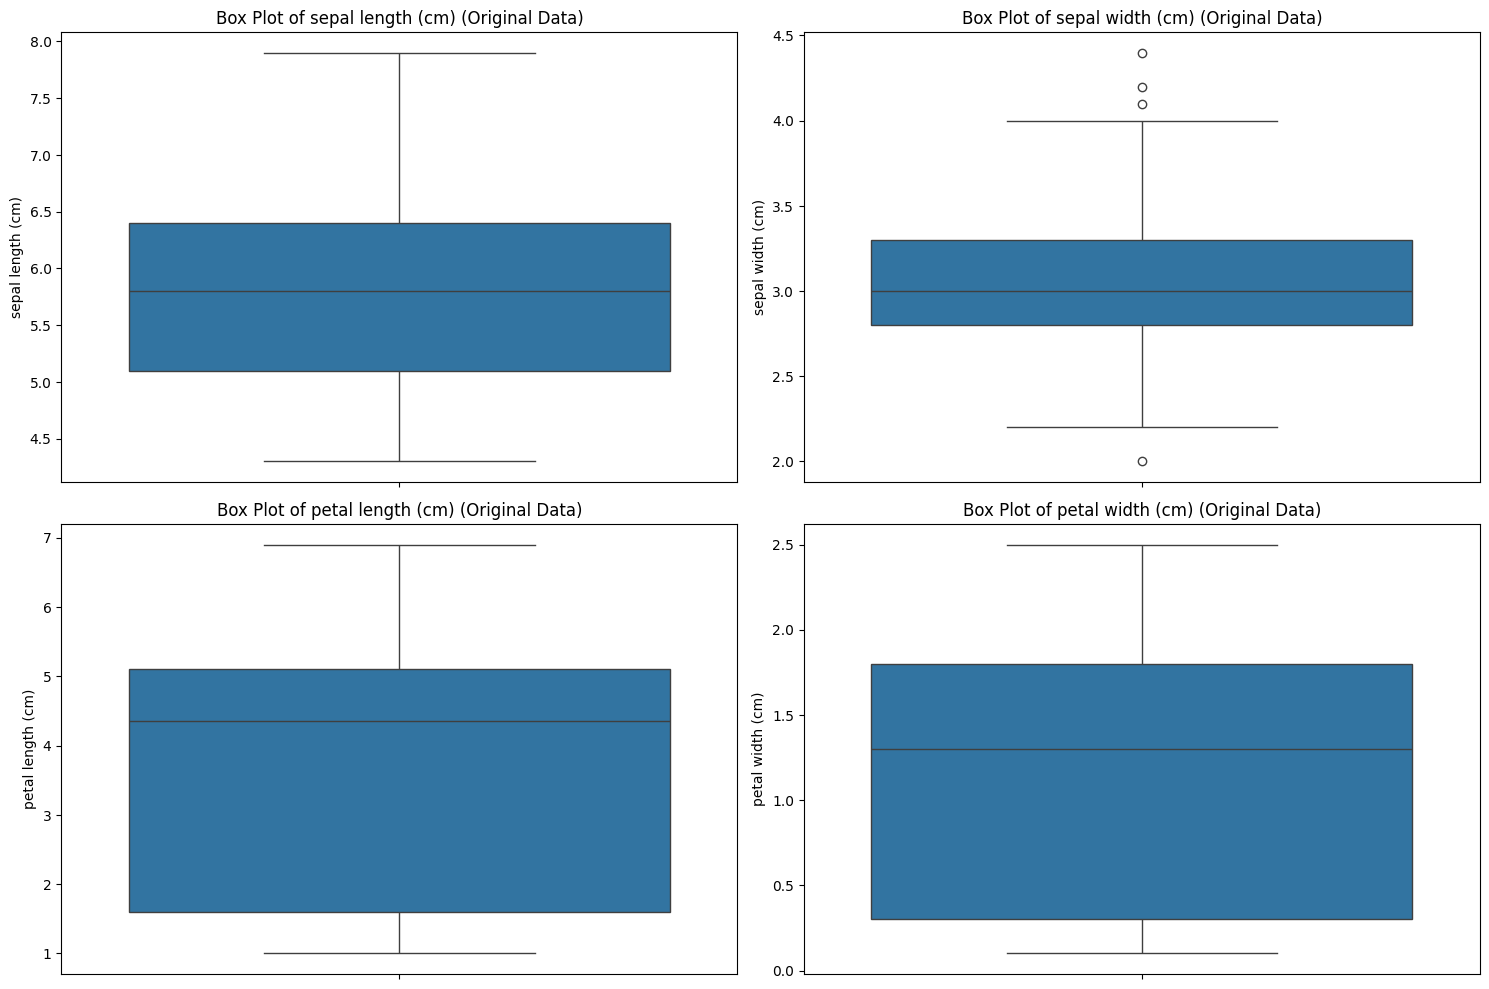

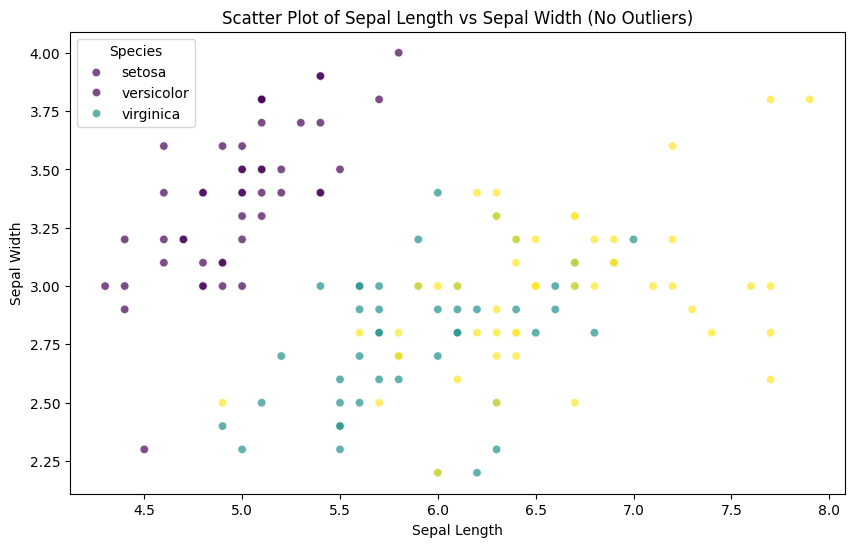

In [63]:
# Outlier Visualization

# Function to identify and remove outliers based on IQR
def remove_outliers(df):
    features = df.columns
    outliers_dict = {}

    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identify outliers
        outliers_dict[feature] = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
        
        # Remove outliers
        df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
    
    return df, outliers_dict

# Identify and remove outliers
data_cleaned, outliers_dict = remove_outliers(data_df)

# Print outliers for each feature
for feature, outliers in outliers_dict.items():
    print(f"Outliers in {feature}:\n", outliers)

# Print the new shape of the DataFrame after removing outliers
print("New Shape after removing outliers: ", data_cleaned.shape)

# Add the target column back to the cleaned DataFrame for visualization
data_cleaned['target'] = data['target']  # Re-add target column to cleaned data

# Visualization: Create box plots to visualize outliers for each feature in the original DataFrame
features = data_df.columns  # Features from data_df
plt.figure(figsize=(15, 10))

for i, feature in enumerate(features):
    plt.subplot(2, 2, i + 1)  # Create a 2x2 grid of plots
    sns.boxplot(y=data_df[feature])
    plt.title(f'Box Plot of {feature} (Original Data)')

plt.tight_layout()
plt.show()

# Scatter plot for cleaned data with groups
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_cleaned, x='sepal length (cm)', y='sepal width (cm)', hue='target', palette='viridis', alpha=0.7)
plt.title("Scatter Plot of Sepal Length vs Sepal Width (No Outliers)")
plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")
plt.legend(title='Species', labels=iris.target_names)
plt.show()

In [64]:
# Drop the target column from features DataFrame
labels_clean = data_cleaned["target"].tolist()
data_cleaned_df = data_cleaned.drop(["target"], axis=1)
data_cleaned_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [65]:
data_cleaned

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [66]:
data_cleaned.to_csv('iris_cleaned.csv', index=True)

In [72]:
def spectral_clustering(dataframe, labels, similarity_graph, laplacian, number_of_clusters, local_sigma = None, epsilon = None, k = None):

    # Pairwise distances
    dimension = dataframe.shape[0]
    dist_mat = squareform(pdist(dataframe))

    if similarity_graph == "full":

        #calculate local sigma
        sigmas = np.zeros(dimension)
        for i in tqdm(range(len(dist_mat))):
            sigmas[i] = sorted(dist_mat[i])[local_sigma]

        # Adjaceny matrix with optimal sigma
        adjacency_matrix = np.zeros([dimension, dimension])
        for i in tqdm(range(dimension)):
            for j in range(i+1, dimension):  
                d = np.exp(-1*dist_mat[i,j]**2/(sigmas[i]*sigmas[j]))
                adjacency_matrix[i,j] = d
                adjacency_matrix[j,i] = d

    
    elif similarity_graph == "eps":

        # Adjaceny matrix with epsilon threshold
        adjacency_matrix = np.zeros([dimension, dimension])
        
        for i in tqdm(range(dimension)):
            for j in range(i+1, dimension):
                if dist_mat[i,j] < epsilon:
                    d = 1
                else:
                    d = 0
                adjacency_matrix[i,j] = d
                adjacency_matrix[j,i] = d


    elif similarity_graph == "knn":

        # Adjaceny matrix with k-neighbours
        adjacency_matrix = np.zeros([dimension, dimension])
        
        for i in tqdm(range(dimension)):
            # Sort distances for node i and get indices of the k nearest neighbors
            sorted_indices = np.argsort(dist_mat[i])
            k_nearest_indices = sorted_indices[1:k+1]  # Exclude the node itself
        
            # Update the adjacency matrix
            adjacency_matrix[i, k_nearest_indices] = 1


    else:

        # Adjaceny matrix with mutual k-neighbours
        adjacency_matrix = np.zeros([dimension, dimension])
        
        for i in tqdm(range(dimension)):
            # Sort distances for node i and get indices of the k nearest neighbors
            sorted_indices = np.argsort(dist_mat[i])
            k_nearest_indices = sorted_indices[1:k+1]  # Exclude the node itself
        
            for neighbor in k_nearest_indices:
                # Check if node i is also among the k-nearest neighbors of the current neighbor
                neighbor_sorted_indices = np.argsort(dist_mat[neighbor])
                if i in neighbor_sorted_indices[1:k+1]:
                    # Connect nodes if they are mutual k-nearest neighbors
                    adjacency_matrix[i, neighbor] = 1
                    adjacency_matrix[neighbor, i] = 1

    # Calculate degree matrix
    degree_matrix = np.sum(adjacency_matrix, axis=0) * np.eye(dimension)

    if laplacian == "sym":

        # Normalized Symmetric laplacian matrix
        d_half = linalg.fractional_matrix_power(degree_matrix, -0.5)
        laplacian_matrix_normalized = np.matmul(np.matmul(d_half, adjacency_matrix), d_half)

    if laplacian == "rw":

        # Normalized Random Walk laplacian matrix
        d_inverse = linalg.fractional_matrix_power(degree_matrix, -1)
        laplacian_matrix_normalized = np.matmul(d_inverse, adjacency_matrix)

    if laplacian == "ad":
        
        # Adaptive Laplacian matrix
        degree_vector = np.diag(degree_matrix)
        D_local = np.zeros_like(degree_vector)
        
        for i in range(len(degree_vector)):
            neighbors = np.where(adjacency_matrix[i] > 0)[0]
            if len(neighbors) > 0:
                D_local[i] = np.sum(degree_vector[neighbors]) / degree_vector[i]
            else:
                D_local[i] = 0
        
        D_local_matrix = np.diag(D_local)
        D_local_inv  = linalg.fractional_matrix_power(D_local_matrix, -0.5)
        laplacian_matrix_normalized = np.matmul(np.matmul(D_local_inv, adjacency_matrix), D_local_inv)
        
    if check_symmetric(laplacian_matrix_normalized) :
        # Calculating eigenvalues and eigenvectors for symmetric matrix
        e, v = np.linalg.eigh(laplacian_matrix_normalized)
    else:
        # Calculating eigenvalues and eigenvectors for non-symmetric matrix
        e, v = np.linalg.eig(laplacian_matrix_normalized)
        idx = np.argsort(np.real(e))
        e = np.real(e[idx])
        v = np.real(v[:, idx]) 
    
    # Calculate eigengap
    eigengap = np.diff(e)
    optimal_number_of_clusters = np.argmax(eigengap[:10]) + 1    
    
    # Use the user-defined k, 2k, and eigengap for clustering
    k_values = [number_of_clusters, 2*number_of_clusters, optimal_number_of_clusters]

    results = []
    
    for i, current_k in enumerate(k_values):
        if i == 0:
            # First case: k
            X = v[:, -number_of_clusters:]
            n_clusters = number_of_clusters
        elif i == 1:
            # Second case: 2k
            X = v[:, -(2*number_of_clusters):]
            n_clusters = number_of_clusters
        else:
            # Third case: optimal number of clusters from eigengap
            X = v[:, -optimal_number_of_clusters:]
            n_clusters = optimal_number_of_clusters
    
        # KMeans clustering
        clustering = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = clustering.fit_predict(X)

        # Calculate evaluation metrics
        sil_score = silhouette_coefficient(dataframe, cluster_labels)[3]
        ar_score = adjusted_rand_score(labels, cluster_labels)
        am_score =  adjusted_mutual_info_score(labels, cluster_labels)

        results.append((sil_score, ar_score, am_score, current_k,cluster_labels))

    return results

In [73]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

In [74]:
def euclidean_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

def calculate_cohesion(point, cluster_points):
    if len(cluster_points) == 0:
        return 0.0
    distances = [euclidean_distance(point, other_point) for other_point in cluster_points]
    return np.mean(distances)

def calculate_separation(point, other_clusters):
    if len(other_clusters) == 0:
        return 0.0
    min_distances = [np.min([euclidean_distance(point, other_point) for other_point in cluster_points]) for cluster_points in other_clusters]
    return np.mean(min_distances)

def silhouette_coefficient(df, clusters):
    num_points = len(df)
    all_cohesion = []
    all_separation = []
    all_silhouette = []

    for i in range(num_points):
        point = df.iloc[i].values.astype(float)  # Convert to numeric
        cluster_index = clusters[i]
        cluster_points = df[clusters == cluster_index].values.astype(float)

        a = calculate_cohesion(point, cluster_points)
        all_cohesion.append(a)

        other_clusters = [df[clusters == idx].values.astype(float) for idx in set(clusters) if idx != cluster_index]
        b = calculate_separation(point, other_clusters)
        all_separation.append(b)

        silhouette_value = (b - a) / max(a, b) if max(a, b) != 0 else 0.0
        all_silhouette.append(silhouette_value)

    avg_silhouette = np.mean(all_silhouette)

    return all_cohesion, all_separation, all_silhouette, avg_silhouette

In [88]:
def get_dynamic_search_space(data):
    # Number of points in the dataset
    n = data.shape[0]

    # Compute pairwise distances
    dist_mat = squareform(pdist(data))
    flat_distances = dist_mat[np.tril_indices(n, -1)]

    # Dynamic range for local_sigma (based on square root of n)
    local_sigma_min = max(1, int(np.sqrt(n) / 2))
    local_sigma_max = int(np.sqrt(n))
    
    # Dynamic range for epsilon (based on distance percentiles)
    epsilon_min = np.percentile(flat_distances, 80)  # 80th percentile
    epsilon_max = np.percentile(flat_distances, 95)  # 95th percentile
    
    # Dynamic range for k (based on number of data points)
    k_min = max(5, int(0.01 * n))  # 1% of dataset size, but at least 5
    k_max = min(int(0.2 * n), n - 1)  # 20% of dataset size, but never more than n-1
    
    # Ensure k_min does not exceed k_max
    if k_min > k_max:
        k_min = max(5, int(0.01 * n))  # Keep dynamic range based on percentage but within limits
    
    search_space = [
        Categorical(["full", "eps", "knn", "mknn"], name='similarity_graph'),  # Test all similarity graphs
        Integer(local_sigma_min, local_sigma_max, name='local_sigma'),          # Dynamic local_sigma for "full" graph
        Real(epsilon_min, epsilon_max, name='epsilon'),                         # Dynamic epsilon for "eps" graph
        Integer(k_min, k_max, name='k')                                         # Dynamic k for "knn" and "mknn"
    ]
    
    return search_space

def optimize_spectral_across_laplacians(params):
    similarity_graph, local_sigma, epsilon, k = params
    laplacian_methods = ['sym', 'rw', 'ad']  # Evaluate for all Laplacians
    silhouette_scores = []

    try:
        for laplacian_method in laplacian_methods:
            if similarity_graph == "full":
                results = spectral_clustering(data_cleaned_df, labels_clean, 
                                               similarity_graph="full", laplacian=laplacian_method, 
                                               number_of_clusters=3, local_sigma=local_sigma)
            elif similarity_graph == "eps":
                results = spectral_clustering(data_cleaned_df, labels_clean, 
                                               similarity_graph="eps", laplacian=laplacian_method, 
                                               number_of_clusters=3, epsilon=epsilon)
            elif similarity_graph == "knn" or similarity_graph == "mknn":
                results = spectral_clustering(data_cleaned_df, labels_clean, 
                                               similarity_graph=similarity_graph, laplacian=laplacian_method, 
                                               number_of_clusters=3, k=k)

            sil_score = results[0][0]  # Assume results[0][0] contains the silhouette score
            silhouette_scores.append(sil_score)  # Store positive scores

        # Aggregate performance across Laplacians (e.g., average or minimum)
        average_score = np.mean(silhouette_scores)  # Average performance
        variance_score = np.var(silhouette_scores)  # Variance of performance
        
        # We aim for minimizing the negative average and variance
        combined_score = average_score - variance_score  # Minimize variance as well for consistency
        return -combined_score  # We are minimizing, so return negative

    except (ValueError, np.linalg.LinAlgError) as e:
        print(f"Skipping parameters: {params} due to error: {e}")
        return 1e6  # Return a large value to penalize the failed set of hyperparameters

In [89]:
# Assume data_cleaned_df is your dataset in numpy format
search_space = get_dynamic_search_space(data_cleaned_df)

# After running gp_minimize
result = gp_minimize(optimize_spectral_across_laplacians, 
                     search_space, 
                     n_calls=50,  # Number of function evaluations
                     n_random_starts=10,  # Start with random points before focusing
                     random_state=42)  # For reproducibility

# Retrieve the best hyperparameters and corresponding score
if result.fun < 1e6:
    print("Best hyperparameters found across all cases:")
    best_similarity_graph = result.x[0]
    best_local_sigma = result.x[1]
    best_epsilon = result.x[2]
    best_k = result.x[3]
    
    print(f"Best similarity graph: {best_similarity_graph}")
    print(f"Best local_sigma: {best_local_sigma}")
    print(f"Best epsilon: {best_epsilon}")
    print(f"Best k: {best_k}")
    
    # The score (in your case, negative average silhouette score)
    best_score = -result.fun  # Convert back to positive
    print(f"Best average silhouette score across all cases: {best_score}")
else:
    print("No valid hyperparameters found. All combinations led to errors.")

100%|███████████████████████████████████████| 146/146 [00:00<00:00, 8955.90it/s]


Skipping parameters: [np.str_('mknn'), np.int64(10), 5.31112039575278, np.int64(5)] due to error: Array must not contain infs or NaNs


100%|██████████████████████████████████████| 146/146 [00:00<00:00, 16982.40it/s]


Best hyperparameters found across all cases:
Best similarity graph: mknn
Best local_sigma: 6
Best epsilon: 5.3019242324702684
Best k: 20
Best average silhouette score across all cases: 0.6355731289386989


In [90]:
similarity_graphs = ["full", "eps", "knn", "mknn"]
laplacian_methods = ["sym", "rw","ad"]
silhouette_scores = []
adjusted_rand_scores = []
adjusted_mutual_info_scores = []
clusters = []
sim_graph = []
laplacian = []
cluster_labels = []
best_local_sigma = int(best_local_sigma)
best_epsilon = int(best_epsilon)
best_k = int(best_k)

for graph in similarity_graphs:

    for laplace in laplacian_methods:
        metrics = spectral_clustering(data_cleaned_df, labels_clean, graph, laplace, 3, local_sigma, epsilon, k)
        
        for si, ar, am, cl, l in metrics:
            sim_graph.append(graph)
            laplacian.append(laplace)
            
            silhouette_scores.append(si)
            adjusted_rand_scores.append(ar)
            clusters.append(cl)
            adjusted_mutual_info_scores.append(am)
            cluster_labels.append(l)

100%|███████████████████████████████████████| 146/146 [00:00<00:00, 9320.25it/s]


In [91]:
experiment_iris = pd.DataFrame(list(zip(sim_graph,laplacian,silhouette_scores,adjusted_rand_scores,adjusted_mutual_info_scores,clusters)), 
             columns= ["graph","laplacian", "silhouette", "adjusted_rand","adjusted_mutual_info","clusters"])
experiment_iris["graph_laplacian"] = experiment_iris["graph"] + "_" + experiment_iris["laplacian"]
experiment_iris

,graph,laplacian,silhouette,adjusted_rand,adjusted_mutual_info,clusters,graph_laplacian
0,full,sym,0.642422,0.733419,0.769506,3,full_sym
1,full,sym,-0.255059,0.183237,0.298737,6,full_sym
2,full,sym,0.642422,0.733419,0.769506,3,full_sym
3,full,rw,0.642422,0.733419,0.769506,3,full_rw
4,full,rw,0.257592,0.266607,0.419105,6,full_rw
5,full,rw,0.642422,0.733419,0.769506,3,full_rw
6,full,ad,0.432397,0.554673,0.597905,3,full_ad
7,full,ad,0.259763,0.164617,0.337401,6,full_ad
8,full,ad,0.432397,0.554673,0.597905,3,full_ad
9,eps,sym,0.360663,0.244794,0.419415,3,eps_sym


In [92]:
# Finding the best results for each metric and their indices
best_silhouette_index = experiment_iris['silhouette'].idxmax()
best_adjusted_rand_index = experiment_iris['adjusted_rand'].idxmax()
adjusted_mutual_info_index = experiment_iris['adjusted_mutual_info'].idxmax()

best_silhouette = experiment_iris.loc[best_silhouette_index]
best_adjusted_rand = experiment_iris.loc[best_adjusted_rand_index]
best_adjusted_mutual_info = experiment_iris.loc[adjusted_mutual_info_index]

# Create a clearer DataFrame with the best results and their indices
best_results = pd.DataFrame({
    'Metric': ['Best Silhouette', 'Best Adjusted Rand', 'Best Adjusted Mutual Info'],
    'Index': [
        best_silhouette_index,
        best_adjusted_rand_index,
        adjusted_mutual_info_index
    ],
    'Graph': [
        best_silhouette['graph'],
        best_adjusted_rand['graph'],
        best_adjusted_mutual_info['graph']
    ],
    'Laplacian': [
        best_silhouette['laplacian'],
        best_adjusted_rand['laplacian'],
        best_adjusted_mutual_info['laplacian']
    ],
    'Silhouette Score': [
        best_silhouette['silhouette'],
        None,  # Placeholder for clarity
        None   # Placeholder for clarity
    ],
    'Adjusted Rand Index': [
        None,  # Placeholder for clarity
        best_adjusted_rand['adjusted_rand'],
        None   # Placeholder for clarity
    ],
    'Adjusted Mutual Info': [
        None,  # Placeholder for clarity
        None,  # Placeholder for clarity
        best_adjusted_mutual_info['adjusted_mutual_info']
    ],
    'Clusters': [
        best_silhouette['clusters'],
        best_adjusted_rand['clusters'],
        best_adjusted_mutual_info['clusters']
    ]
})

# Display the best results
best_results

,Metric,Index,Graph,Laplacian,Silhouette Score,Adjusted Rand Index,Adjusted Mutual Info,Clusters
0,Best Silhouette,35,mknn,ad,0.653945,NaN,NaN,4
1,Best Adjusted Rand,33,mknn,ad,NaN,0.880594,NaN,3
2,Best Adjusted Mutual Info,33,mknn,ad,NaN,NaN,0.857027,3


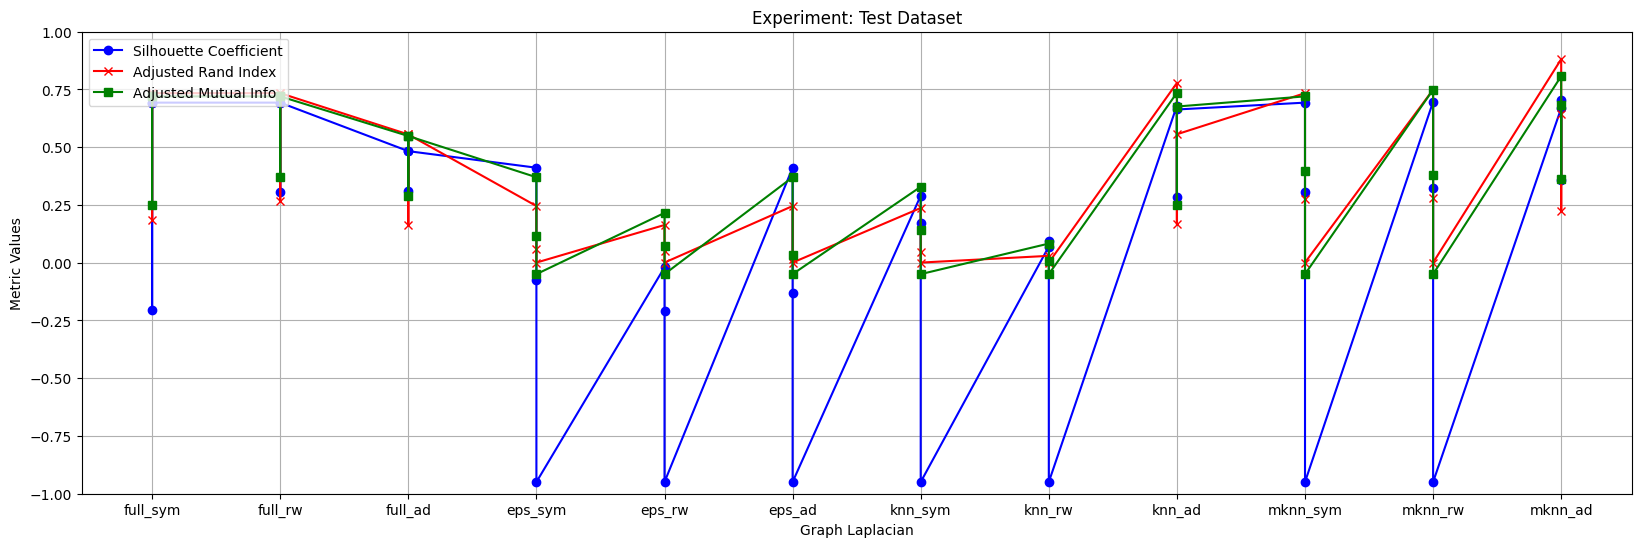

In [80]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(20, 6))

# Define an offset to avoid overlap
offset = 0.05

# Plot silhouette coefficient with an offset
ax.plot(experiment_iris['graph_laplacian'], 
        experiment_iris['silhouette'] + offset, 
        marker='o', color='b', label='Silhouette Coefficient', markersize=6)

# Plot Adjusted Rand Index with an offset
ax.plot(experiment_iris['graph_laplacian'], 
        experiment_iris['adjusted_rand'], 
        marker='x', color='r', label='Adjusted Rand Index', markersize=6)

# Plot Adjusted Mutual Information with an offset
ax.plot(experiment_iris['graph_laplacian'], 
        experiment_iris['adjusted_mutual_info'] - offset, 
        marker='s', color='g', label='Adjusted Mutual Info', markersize=6)

# Set labels
ax.set_xlabel('Graph Laplacian')
ax.set_ylabel('Metric Values')

# Adjust y-axis limits dynamically
ax.set_ylim(-1, 1)  # Set limits to fit the offsets

# Add a title
plt.title('Experiment: Test Dataset')

# Add a legend
ax.legend(loc='upper left')

# Show grid for better readability
plt.grid()

# Show the plot
plt.show()

In [81]:
# Visualization function
def visualize_clusters(data, cluster_labels, title):
    """
    Visualize clustered data using PCA.
    
    Parameters:
    data (DataFrame): The original data used for clustering.
    cluster_labels (ndarray): Cluster labels from the clustering algorithm.
    title (str): Title of the plot.
    """
    # Reduce data to 2D using PCA if necessary
    if data.shape[1] > 2:
        pca = PCA(n_components=2)
        reduced_data = pca.fit_transform(data)
    else:
        reduced_data = data.values  # If data is already 2D
    
    # Create scatter plot with clusters
    plt.figure(figsize=(6, 4))
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
    
    # Adding title and labels
    plt.title(f'Cluster Visualization - {title}')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.colorbar(scatter, label='Cluster Label')
    plt.show()

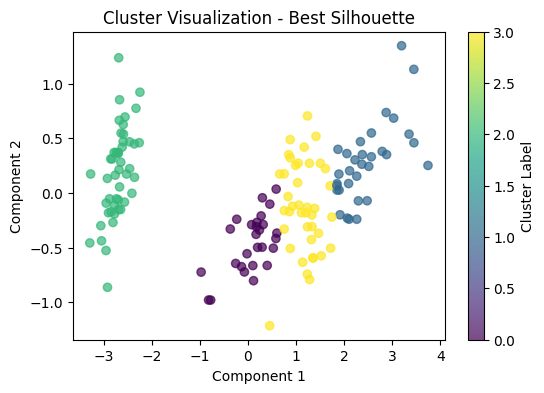

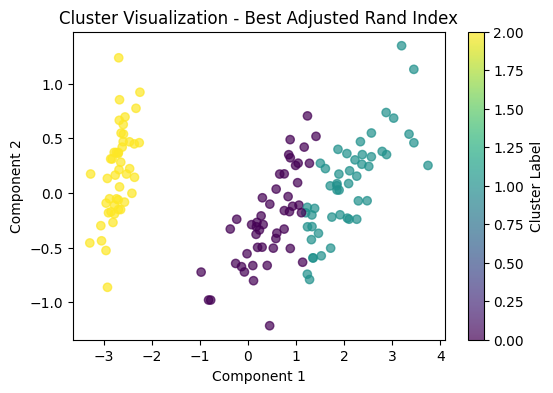

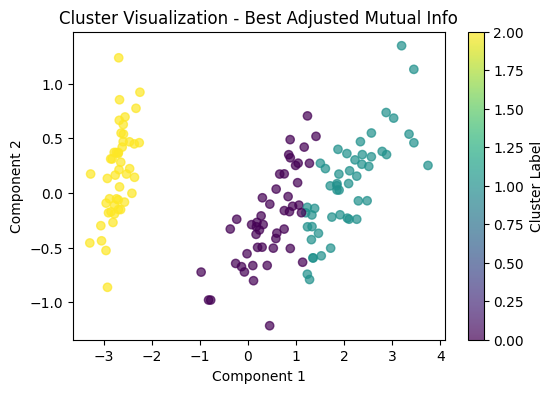

In [82]:
# Extracting cluster labels for best silhouette, adjusted rand, and adjusted mutual info indices
best_silhouette_clusters = cluster_labels[best_silhouette_index]
best_adjusted_rand_clusters = cluster_labels[best_adjusted_rand_index]
best_adjusted_mutual_info_clusters = cluster_labels[adjusted_mutual_info_index]

# Visualizing the best clusters for each metric
visualize_clusters(data_cleaned_df, best_silhouette_clusters, 'Best Silhouette')
visualize_clusters(data_cleaned_df, best_adjusted_rand_clusters, 'Best Adjusted Rand Index')
visualize_clusters(data_cleaned_df, best_adjusted_mutual_info_clusters, 'Best Adjusted Mutual Info')